In [1]:
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from copy import deepcopy

Read saved serialized predictions (see 1vA.ipynb)

In [2]:
with open("results_1vA.pickle", 'rb') as f:
    results = pickle.load(f)
    
datasets = list(results.keys())
datasets


['ajt', 'chd', 'corpas', 'yri']

Compute overall accuracies over all datasets and methods

In [3]:
def accuracy(test, pred_type):
    return accuracy_score(results[test]['y_test'],
                          results[test][pred_type])

data = [[accuracy(test, pred_type) for pred_type in ["preds_naive", "preds_mle", "preds_lr", "preds_xgb"]] for test in datasets]

df = pd.DataFrame(data, columns=["No recal", "MLE", "Logistic regression", "XGBoost"])
df['Trio'] = ['chd', 'ajt', 'corpas', 'yri']
df[['Trio', 'No recal', "MLE", 'Logistic regression', 'XGBoost']]

,Trio,No recal,MLE,Logistic regression,XGBoost
0,chd,0.876236,0.976745,0.976201,0.980431
1,ajt,0.893423,0.929318,0.926893,0.935818
2,corpas,0.903020,0.949930,0.949908,0.957570
3,yri,0.875756,0.967689,0.969716,0.974601


Plot overall results

In [4]:
contaminations = sorted(list(results['ajt']['idx'].keys()))
pred_types = ['preds_naive', 'preds_mle', 'preds_lr', 'preds_xgb', 'preds_meta'
             ]
pred_names = {'preds_naive': "No recalibration",
              'preds_lr': "Logistic regression",
              'preds_xgb': "XGBoost",
              'preds_mle': "MLE",
              'preds_meta': "Meta-classifier",}

metrics = [precision_score, recall_score, f1_score]
metric_names = ["precision", "recall", "f1"]
metric_desc = ["Precision score", "Recall score", "F1 score"]

scores = {}

for test in datasets:
    scores[test] = {}
    
    for pred_type in pred_types:
        scores[test][pred_type] = {}
        for metric, name in zip(metrics, metric_names):
            scores[test][pred_type][name] = []
            for contamination in contaminations:
                scores[test][pred_type][name].append(metric(results[test]['y_test'][results[test]['idx'][contamination]],
                                                            results[test][pred_type][results[test]['idx'][contamination]],
                                                            average='macro'))
        scores[test][pred_type]['accuracy'] = []
        for contamination in contaminations:
                scores[test][pred_type]['accuracy'].append(accuracy_score(results[test]['y_test'][results[test]['idx'][contamination]],
                                                            results[test][pred_type][results[test]['idx'][contamination]],))
metric_names.append('accuracy')

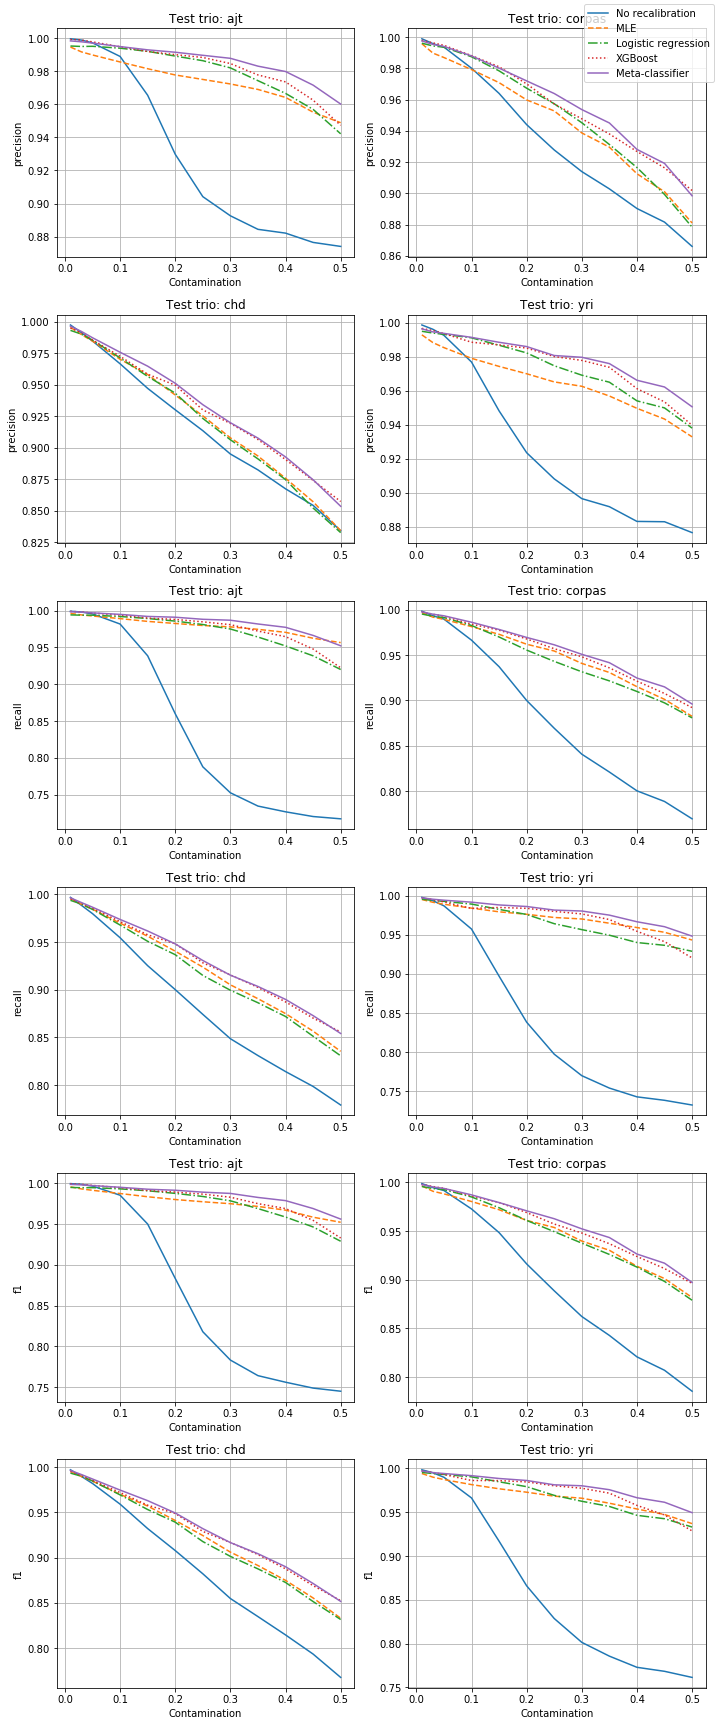

In [5]:
sp, ax = plt.subplots(6, 2, figsize=(10, 24))

linestyles = ['-', '--', '-.', ':', '-']

for j, (metric, name) in enumerate(list(zip(metrics, metric_names))):
    for i, test in enumerate(datasets):
        ax[i%2 + j*2, i//2].set_title("Test trio: {}".format(test))

        for k, pred_type in enumerate(pred_types):
            ax[i%2 + 2*j,i//2].plot(contaminations, scores[test][pred_type][name], label=pred_names[pred_type], linestyle=linestyles[k])


        ax[i%2 +j*2 , i//2].grid()
        ax[i%2 + j*2, i//2].set_xlabel("Contamination")
        ax[i%2 +j*2, i//2].set_ylabel(name)

plt.tight_layout()
handles, labels = ax[1, 1].get_legend_handles_labels()
sp.legend(handles, labels, loc='upper right')
# sp.savefig('accuracies.eps', format='eps', dpi=1000)

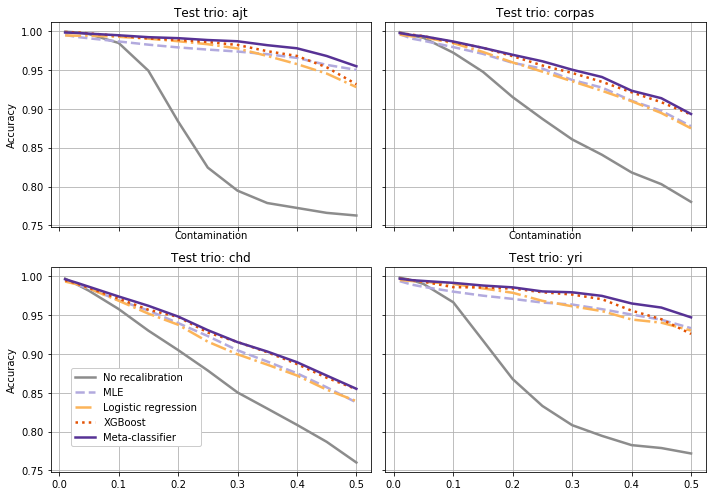

In [6]:
sp, ax = plt.subplots(2, 2, figsize=(10, 7), sharex=True, sharey=True)

linestyles = ['-', '--', '-.', ':', "-", "--"]
colors = ['#8c8c8c', '#b2aade', '#fcb459', '#e35204', '#573295', "#000000"]

# sp.suptitle('Likelihoods included', fontsize=14)

name = 'accuracy'
for i, test in enumerate(datasets):
    ax[i%2, i//2].set_title("Test trio: {}".format(test))

    for k, pred_type in enumerate(pred_types):
        ax[i%2,i//2].plot(contaminations,
                          [accuracy_score(results[test]['y_test'][results[test]['idx'][c]],
                                          results[test][pred_type][results[test]['idx'][c]]) for c in contaminations],
                          label=pred_names[pred_type], linestyle=linestyles[k], color=colors[k], linewidth=2.5)
    ax[i%2, i//2].grid()
#     ax[i%2, i//2].set_xlim(0, 0.1)
#     ax[i%2, i//2].set_ylim(0.95, 1)
    
ax[0, 0].set_xlabel("Contamination")
ax[0, 1].set_xlabel("Contamination")

ax[0, 0].set_ylabel("Accuracy")
ax[1, 0].set_ylabel("Accuracy")

handles, labels = ax[1, 1].get_legend_handles_labels()
sp.legend(handles, labels, loc=(0.1, 0.1), prop={'size': 10}, framealpha=1)
plt.tight_layout()
# sp.savefig('accuracies.eps', format='eps', dpi=1000)

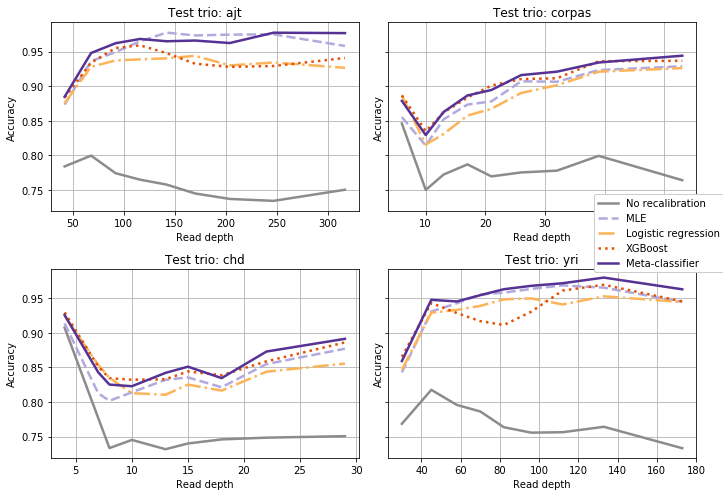

In [7]:
sp, ax = plt.subplots(2, 2, figsize=(10, 7), sharey=True)

linestyles = ['-', '--', '-.', ':', "-", '-', "--"]
colors = ['#8c8c8c', '#b2aade', '#fcb459', '#e35204', '#573295', "#000000"]

c = 0.5

name = 'accuracy'
for i, test in enumerate(datasets):
    ax[i%2, i//2].set_title("Test trio: {}".format(test))
    
    edges = [np.percentile(results[test]['dp'], 10*i) for i in range(1,10)]
    bin_idx = np.digitize(results[test]['dp'], edges)
    
    
    for k, pred_type in enumerate(pred_types):
        ax[i%2,i//2].plot(edges,
                          [accuracy_score(results[test]['y_test'][np.logical_and(bin_idx == i, results[test]['idx'][c])],
                                          results[test][pred_type][np.logical_and(bin_idx == i, results[test]['idx'][c])]) for i in range(9)],
                          label=pred_names[pred_type], linestyle=linestyles[k], color=colors[k], linewidth=2.5)
    ax[i%2, i//2].grid()
    ax[i%2, i//2].set_xlabel("Read depth")
    ax[i%2, i//2].set_ylabel("Accuracy")

handles, labels = ax[1, 1].get_legend_handles_labels()
sp.legend(handles, labels, loc=(0.82, 0.45), prop={'size': 10}, framealpha=1)
plt.tight_layout()
# sp.savefig('accuracies_read_depth.eps', format='eps', dpi=1000)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

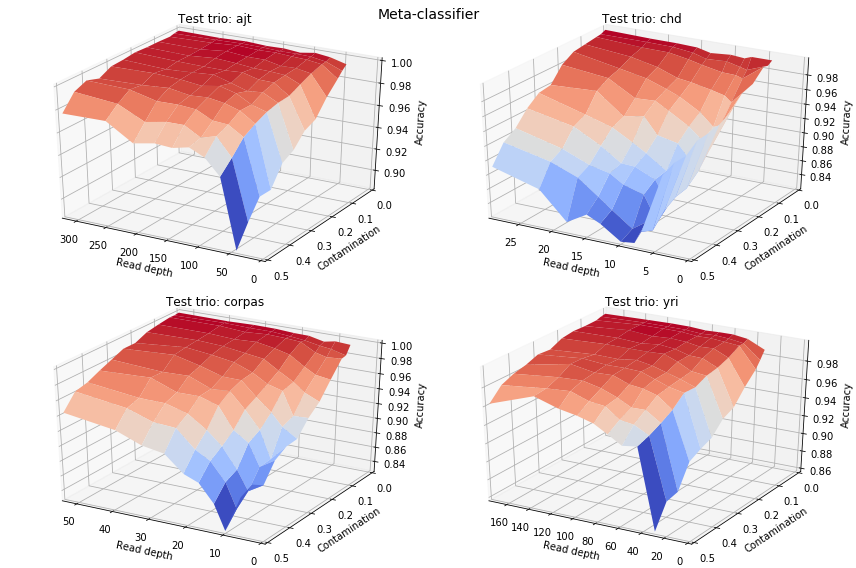

In [8]:
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm

# sp, ax = plt.subplots(2, 2, figsize=(10, 7), sharey=True)
fig = plt.figure(figsize=(12, 8))
linestyles = ['-', '--', '-.', ':', "-", '-']
colors = ['#8c8c8c', '#b2aade', '#fcb459', '#e35204', '#573295']

fig.suptitle('Meta-classifier', fontsize=14)

name = 'accuracy'
for i, test in enumerate(datasets):
#     ax[i%2, i//2].set_title("Test trio: {}".format(test))
    
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
#     ax = sp.gca(projection='3d')
    ax.set_title("Test trio: {}".format(test))
    edges = [np.percentile(results[test]['dp'], 10*i) for i in range(1,10)]
    bin_idx = np.digitize(results[test]['dp'], edges)
    
    X, Y = np.meshgrid(edges, contaminations)
    Z = [[accuracy_score(results[test]['y_test'][np.logical_and(bin_idx == i, results[test]['idx'][c])],
                        results[test]['preds_meta'][np.logical_and(bin_idx == i, results[test]['idx'][c])]) for i in range(9)] for c in contaminations]
    Z = np.array(Z)
    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)
    ax.invert_yaxis()
    ax.set_xlim(edges[-1], 0)
    ax.set_ylim(0.5, 0)
#     ax.invert_xaxis()
    
#     for k, pred_type in enumerate(pred_types):
#         ax[i%2,i//2].plot(edges,
#                           [accuracy_score(results[test]['y_test'][np.logical_and(bin_idx == i, results[test]['idx'][0.2])],
#                                           results[test][pred_type][np.logical_and(bin_idx == i, results[test]['idx'][0.2])]) for i in range(9)],
#                           label=pred_names[pred_type], linestyle=linestyles[k], color=colors[k], linewidth=2.5)
#     ax[i%2, i//2].grid()
    ax.set_xlabel("Read depth")
    ax.set_zlabel("Accuracy")
    ax.set_ylabel("Contamination")

# handles, labels = ax[1, 1].get_legend_handles_labels()
# sp.legend(handles, labels, loc=(0.82, 0.45), prop={'size': 10}, framealpha=1)
plt.tight_layout()
plt.savefig('accuracies_read_depth_contamination_meta.eps', format='eps', dpi=1000)

In [ ]:
sp, ax = plt.subplots(2, 2, figsize=(10, 7), sharex=True, sharey=True)

linestyles = ['-', '--', '-.', ':', "-"]
colors = ['#8c8c8c', '#b2aade', '#fcb459', '#e35204', '#573295']

name = 'accuracy'
for i, test in enumerate(datasets):
    ax[i%2, i//2].set_title("Test trio: {}".format(test))

    for k, pred_type in enumerate(pred_types):
        ax[i%2,i//2].plot(contaminations,
                          [np.sum(results[test]['preds_naive'][results[test]['idx'][c]] !=
                                          results[test][pred_type][results[test]['idx'][c]]) for c in contaminations],
                          label=pred_names[pred_type], linestyle=linestyles[k], color=colors[k], linewidth=2.5)
    ax[i%2, i//2].grid()
    ax[i%2, i//2].set_xlabel("Contamination")
    ax[i%2, i//2].set_ylabel("# of recalibrated positions")

handles, labels = ax[1, 1].get_legend_handles_labels()
sp.legend(handles, labels, loc=(0.1, 0.3), prop={'size': 10}, framealpha=1)
plt.tight_layout()
# sp.savefig('accuracies.eps', format='eps', dpi=1000)

In [ ]:
sp, ax = plt.subplots(2, 2, figsize=(10, 7), sharex=True, sharey=True)

linestyles = ['-', '--', '-.', ':', "-"]
colors = ['#8c8c8c', '#b2aade', '#fcb459', '#e35204', '#573295']

name = 'accuracy'
for i, test in enumerate(datasets):
    ax[i%2, i//2].set_title("Test trio: {}".format(test))

    for k, pred_type in enumerate(pred_types):
        ax[i%2,i//2].plot(contaminations,
                          [accuracy_score(results[test]['y_test'][results[test]['idx'][c]],
                                          results[test][pred_type][results[test]['idx'][c]]) for c in contaminations],
                          label=pred_names[pred_type], linestyle=linestyles[k], color=colors[k], linewidth=2.5, )
    ax[i%2, i//2].grid()
    ax[i%2, i//2].set_xlabel("Contamination")
    ax[i%2, i//2].set_ylabel("Accuracy")
    ax[i%2, i//2].set_xlim([0, 0.1])
    
    ax[i%2, i//2].set_ylim([0.96, 1])

handles, labels = ax[1, 1].get_legend_handles_labels()
sp.legend(handles, labels, loc=(0.1, 0.1), prop={'size': 10}, framealpha=1)
plt.tight_layout()
sp.savefig('accuracies.eps', format='eps', dpi=1000)

In [ ]:
sp, ax = plt.subplots(2, 2, figsize=(10, 7), sharex=False, sharey=True)

linestyles = ['-', '--', '-.', ':', "-", '-']

name = 'accuracy'
for i, test in enumerate(['ajt', 'yri']):
    ax[0, i].set_title("Test trio: {}".format(test))
    
    edges = [np.percentile(results[test]['dp'], 10*i) for i in range(1,10)]
    bin_idx = np.digitize(results[test]['dp'], edges)
    
    
    for k, pred_type in enumerate(['preds_naive', 'preds_meta']):
        ax[0,i].plot(edges,
                          [accuracy_score(results[test]['y_test'][np.logical_and(bin_idx == i, results[test]['idx'][0.2])],
                                          results[test][pred_type][np.logical_and(bin_idx == i, results[test]['idx'][0.2])]) for i in range(9)],
                          label=pred_names[pred_type], linestyle=linestyles[1-k], linewidth=2.5, color=colors[-k])
    ratios = []
    for bin_id in range(len(edges)):
        af_idx = np.logical_and(bin_idx == bin_id, results[test]['idx'][0.2])
        recal = np.sum(results[test]['preds_meta'][af_idx] != results[test]['preds_naive'][af_idx])
        recal_correct = np.sum(np.logical_and(results[test]['preds_meta'][af_idx] != results[test]['preds_naive'][af_idx],
                                              results[test]['preds_meta'][af_idx] == results[test]['y_test'][af_idx])
                                        )
        ratios.append(recal_correct/recal)

    ax[1,i].plot(edges,
                      ratios,
                      label=pred_names[pred_type], linestyle=linestyles[0], linewidth=2.5, color=colors[-1])
    ax[0, i].grid()
    ax[0, i].set_xlabel("Read depth")
    ax[0, i].set_ylabel("Accuracy")
    
    ax[1, i].grid()
    ax[1, i].set_xlabel("Read depth")
    ax[1, i].set_ylabel("Fraction of positions recalibrated correctly")

handles, labels = ax[0, 0].get_legend_handles_labels()
sp.legend(handles, labels, loc=(0.8, 0.1), prop={'size': 10}, framealpha=1)
plt.tight_layout()
sp.savefig('accuracies_read_depth_meta.eps', format='eps', dpi=1000)

In [ ]:
sp, ax = plt.subplots(2, 2, figsize=(10, 7), sharex=False, sharey=True)

linestyles = ['-', '--', '-.', ':', "-", '-']

name = 'accuracy'
for i, test in enumerate(datasets):
    ax[i%2, i//2].set_title("Test trio: {}".format(test))
    
    edges = [np.percentile(results[test]['dp'], 100/18*i) for i in range(1,18)]
    bin_idx = np.digitize(results[test]['dp'], edges)
    
    
    for k, pred_type in enumerate(pred_types):
        accuracies = [accuracy_score(results[test]['y_test'][np.logical_and(bin_idx == j, results[test]['idx'][0.2])],
                                     results[test][pred_type][np.logical_and(bin_idx == j, results[test]['idx'][0.2])]) for j in range(17)]
#         print(test, pred_type, accuracies)
        ax[i%2, i//2].plot(edges,
                          accuracies,
                          label=pred_names[pred_type], linestyle=linestyles[k], linewidth=2.5, color=colors[k])
#     ratios = []
#     for bin_id in range(len(edges)):
#         af_idx = np.logical_and(bin_idx == bin_id, results[test]['idx'][0.2])
#         recal = np.sum(results[test]['preds_meta'][af_idx] != results[test]['preds_naive'][af_idx])
#         recal_correct = np.sum(np.logical_and(results[test]['preds_meta'][af_idx] != results[test]['preds_naive'][af_idx],
#                                               results[test]['preds_meta'][af_idx] == results[test]['y_test'][af_idx])
#                                         )
#         ratios.append(recal_correct/recal)

#     ax[i%2, i//2].plot(edges,
#                       ratios,
#                       label=pred_names[pred_type], linestyle=linestyles[0], linewidth=2.5, color=colors[-1])
    ax[i%2, i//2].grid()
    ax[i%2, i//2].set_xlabel("Read depth")
    ax[i%2, i//2].set_ylabel("Accuracy")
    
#     ax[1, i].grid()
#     ax[1, i].set_xlabel("Read depth")
#     ax[1, i].set_ylabel("Fraction of positions recalibrated correctly")

handles, labels = ax[0, 0].get_legend_handles_labels()
sp.legend(handles, labels, loc=(0.78, 0.15), prop={'size': 10}, framealpha=1)
plt.tight_layout()
sp.savefig('accuracies_read_depth.eps', format='eps', dpi=1000)

In [ ]:
sp, ax = plt.subplots(2, 2, figsize=(10, 7), sharex=False, sharey=False)

linestyles = ['-', '--', '-.', ':', "-", '-']

name = 'accuracy'
for i, test in enumerate(datasets):
    ax[i%2, i//2].set_title("Test trio: {}".format(test))
    
    edges = [np.percentile(results[test]['dp'], 10*i) for i in range(1,10)]
    bin_idx = np.digitize(results[test]['dp'], edges)
    
    
    for k, pred_type in enumerate(pred_types):
        ax[i%2, i//2].plot(edges,
                          [np.sum(results[test]['y_test'][np.logical_and(bin_idx == i, results[test]['idx'][0.2])] !=
                                  results[test][pred_type][np.logical_and(bin_idx == i, results[test]['idx'][0.2])]) for i in range(9)],
                          label=pred_names[pred_type], linestyle=linestyles[k], linewidth=2.5, color=colors[k])
    #     ratios = []
    #     for bin_id in range(len(edges)):
    #         af_idx = np.logical_and(bin_idx == bin_id, results[test]['idx'][0.2])
    #         recal = np.sum(results[test]['preds_meta'][af_idx] != results[test]['preds_naive'][af_idx])
    #         recal_correct = np.sum(np.logical_and(results[test]['preds_meta'][af_idx] != results[test]['preds_naive'][af_idx],
    #                                               results[test]['preds_meta'][af_idx] == results[test]['y_test'][af_idx])
    #                                         )
    #         ratios.append(recal_correct/recal)

    #     ax[i%2, i//2].plot(edges,
    #                       ratios,
    #                       label=pred_names[pred_type], linestyle=linestyles[0], linewidth=2.5, color=colors[-1])
    ax[i%2, i//2].grid()
    ax[i%2, i//2].set_xlabel("Read depth")
    ax[i%2, i//2].set_ylabel("# mis-called positions")
    
#     ax[1, i].grid()
#     ax[1, i].set_xlabel("Read depth")
#     ax[1, i].set_ylabel("Fraction of positions recalibrated correctly")

handles, labels = ax[0, 0].get_legend_handles_labels()
sp.legend(handles, labels, loc=(0.8, 0.1), prop={'size': 10}, framealpha=1)
plt.tight_layout()
# sp.savefig('accuracies_read_depth_meta.eps', format='eps', dpi=1000)

In [ ]:
sp, ax = plt.subplots(2, 2, figsize=(10, 7), sharex=True, sharey=True)

linestyles = ['-', '--', '-.', ':', "-"]
colors = ['#8c8c8c', '#b2aade', '#fcb459', '#e35204', '#573295']

name = 'accuracy'
for i, test in enumerate(datasets):
    ax[i%2, i//2].set_title("Test trio: {}".format(test))

    for k, pred_type in enumerate(pred_types):
        ax[i%2,i//2].plot(contaminations,
                          [np.sum(results[test]['y_test'][results[test]['idx'][c]] !=
                                          results[test][pred_type][results[test]['idx'][c]])/
                              np.sum(results[test]['preds_naive'][results[test]['idx'][c]] !=
                                          results[test]['y_test'][results[test]['idx'][c]]) for c in contaminations],
                          label=pred_names[pred_type], linestyle=linestyles[k], color=colors[k], linewidth=2.5)
    ax[i%2, i//2].grid()
    
    ax[i%2, i//2].set_ylim([0, 1])
    ax[i%2, i//2].set_xlabel("Contamination")
    ax[i%2, i//2].set_ylabel("% of mis-called positions")

handles, labels = ax[1, 1].get_legend_handles_labels()
sp.legend(handles, labels, loc=(0.1, 0.3), prop={'size': 10}, framealpha=1)
plt.tight_layout()
# sp.savefig('accuracies.eps', format='eps', dpi=1000)

In [ ]:
sp, ax = plt.subplots(2, 2, figsize=(10, 7), sharex=True, sharey=True)

linestyles = ['-', '--', '-.', ':', "-"]
colors = ['#8c8c8c', '#b2aade', '#fcb459', '#e35204', '#573295']

name = 'accuracy'
for i, test in enumerate(datasets):
    ax[i%2, i//2].set_title("Test trio: {}".format(test))

    for k, pred_type in enumerate(pred_types):
        ax[i%2,i//2].plot(contaminations,
                          [np.sum(results[test]['y_test'][results[test]['idx'][c]] !=
                                          results[test][pred_type][results[test]['idx'][c]]) for c in contaminations],
                          label=pred_names[pred_type], linestyle=linestyles[k], color=colors[k], linewidth=2.5)
    ax[i%2, i//2].grid()
    
    ax[i%2, i//2].set_xlabel("Contamination")
    ax[i%2, i//2].set_ylabel("# of mis-called positions")

handles, labels = ax[1, 1].get_legend_handles_labels()
sp.legend(handles, labels, loc=(0.1, 0.3), prop={'size': 10}, framealpha=1)
plt.tight_layout()
# sp.savefig('accuracies.eps', format='eps', dpi=1000)

In [ ]:

sp, ax = plt.subplots(2, 2, figsize=(10, 7))

i = 1
test = 'chd'
ax[i%2, i//2].set_title("Test trio: {}".format(test))

edges = [np.percentile(results[test]['dp'], 5*i) for i in range(1,20)]
bin_idx = np.digitize(results[test]['dp'], edges)

j = 5
print(results[test]['y_test'][np.logical_and(bin_idx == j, results[test]['idx'][0.2])])

for k, pred_type in enumerate(pred_types):
    accuracies = [accuracy_score(results[test]['y_test'][np.logical_and(bin_idx == i, results[test]['idx'][0.2])],
                                 results[test][pred_type][np.logical_and(bin_idx == i, results[test]['idx'][0.2])]) for i in range(19)]
    print(test, pred_type, accuracies)
    ax[i%2, i//2].plot(edges,
                      accuracies,
                      label=pred_names[pred_type], linestyle=linestyles[k], linewidth=2.5, color=colors[k])
#     ratios = []
#     for bin_id in range(len(edges)):
#         af_idx = np.logical_and(bin_idx == bin_id, results[test]['idx'][0.2])
#         recal = np.sum(results[test]['preds_meta'][af_idx] != results[test]['preds_naive'][af_idx])
#         recal_correct = np.sum(np.logical_and(results[test]['preds_meta'][af_idx] != results[test]['preds_naive'][af_idx],
#                                               results[test]['preds_meta'][af_idx] == results[test]['y_test'][af_idx])
#                                         )
#         ratios.append(recal_correct/recal)

#     ax[i%2, i//2].plot(edges,
#                       ratios,
#                       label=pred_names[pred_type], linestyle=linestyles[0], linewidth=2.5, color=colors[-1])
ax[i%2, i//2].grid()
ax[i%2, i//2].set_xlabel("Read depth")
ax[i%2, i//2].set_ylabel("Accuracy")

#     ax[1, i].grid()
#     ax[1, i].set_xlabel("Read depth")
#     ax[1, i].set_ylabel("Fraction of positions recalibrated correctly")

handles, labels = ax[0, 0].get_legend_handles_labels()
sp.legend(handles, labels, loc=(0.78, 0.15), prop={'size': 10}, framealpha=1)
plt.tight_layout()

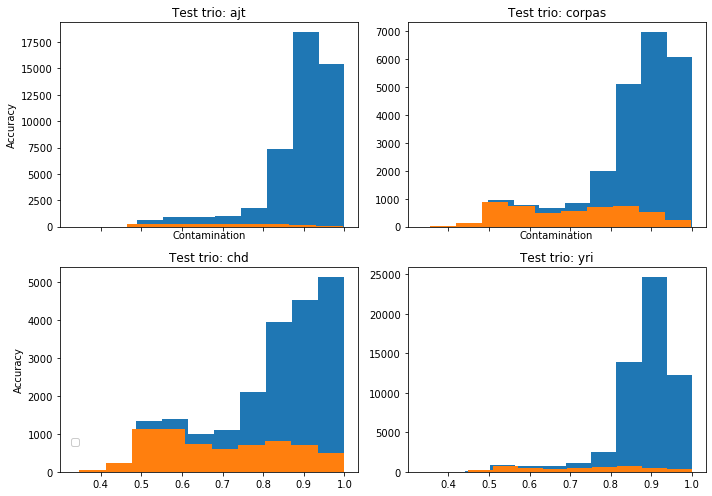

In [33]:
sp, ax = plt.subplots(2, 2, figsize=(10, 7), sharex=True)

linestyles = ['-', '--', '-.', ':', "-", "--"]
colors = ['#8c8c8c', '#b2aade', '#fcb459', '#e35204', '#573295', "#000000"]

# sp.suptitle('Likelihoods included', fontsize=14)

name = 'accuracy'
for i, test in enumerate(datasets):
    ax[i%2, i//2].set_title("Test trio: {}".format(test))
    
    idx_recal = results[test]['preds_naive'] != results[test]['preds_meta']
    idx_correct = results[test]['preds_meta'] == results[test]['y_test']
    
    
    idx_recal_correct = np.logical_and(idx_recal, idx_correct)
    
    idx_recal_incorrect = np.logical_and(idx_recal, ~idx_correct)
    conf = results[test]['probs'].max(axis=1)
    ax[i%2,i//2].hist(conf[idx_recal_correct])
    
    ax[i%2,i//2].hist(conf[idx_recal_incorrect])
#     ax[i%2, i//2].grid()
    
ax[0, 0].set_xlabel("Contamination")
ax[0, 1].set_xlabel("Contamination")

ax[0, 0].set_ylabel("Accuracy")
ax[1, 0].set_ylabel("Accuracy")

handles, labels = ax[1, 1].get_legend_handles_labels()
sp.legend(handles, labels, loc=(0.1, 0.1), prop={'size': 10}, framealpha=1)
plt.tight_layout()
# sp.savefig('accuracies.eps', format='eps', dpi=1000)

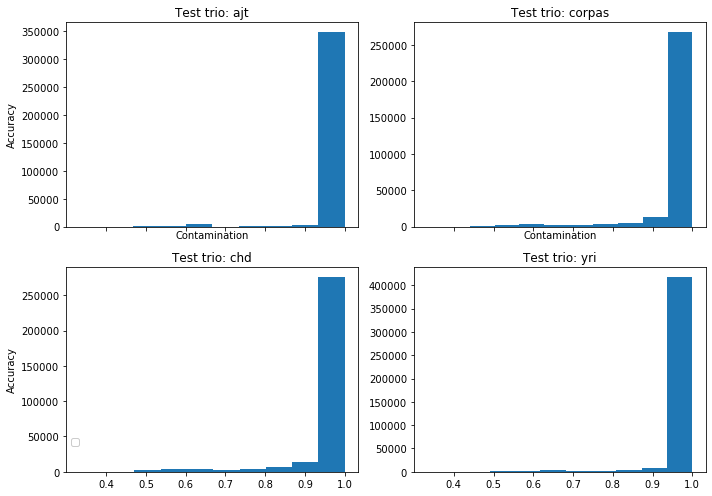

In [31]:
sp, ax = plt.subplots(2, 2, figsize=(10, 7), sharex=True)

linestyles = ['-', '--', '-.', ':', "-", "--"]
colors = ['#8c8c8c', '#b2aade', '#fcb459', '#e35204', '#573295', "#000000"]

# sp.suptitle('Likelihoods included', fontsize=14)

name = 'accuracy'
for i, test in enumerate(datasets):
    ax[i%2, i//2].set_title("Test trio: {}".format(test))
    
    idx_recal = results[test]['preds_naive'] != results[test]['preds_meta']
    idx_correct = results[test]['preds_meta'] == results[test]['y_test']
    
    idx_recal_correct = np.logical_and(idx_recal, idx_correct)
    
    idx_recal_incorrect = np.logical_and(idx_recal, ~idx_correct)
    conf = results[test]['probs'].max(axis=1)
    ax[i%2,i//2].hist(conf[~idx_recal])
    
#     ax[i%2,i//2].hist(conf[idx_recal_incorrect])
#     ax[i%2, i//2].grid()
    
ax[0, 0].set_xlabel("Contamination")
ax[0, 1].set_xlabel("Contamination")

ax[0, 0].set_ylabel("Accuracy")
ax[1, 0].set_ylabel("Accuracy")

handles, labels = ax[1, 1].get_legend_handles_labels()
sp.legend(handles, labels, loc=(0.1, 0.1), prop={'size': 10}, framealpha=1)
plt.tight_layout()
# sp.savefig('accuracies.eps', format='eps', dpi=1000)